# Task 1: Initial Exploration & Summary 

# Import datasets

In [147]:
import pandas as pd

# Load the CSV file into a DataFrame
df1 = pd.read_csv('Data.csv')
df2 = pd.read_csv('material.csv')
df_original1 = df1.copy()
df_original2 = df2.copy()

In [148]:
print(df1.head(10).to_string(index=False))

 Std                               ID       Material Heat treatment  Su  Sy   A5   Bhn      E     G  mu   Ro    pH Desc  HV
ANSI D8894772B88F495093C43AF905AB6373 Steel SAE 1015      as-rolled 421 314 39.0 126.0 207000 79000 0.3 7860   NaN  NaN NaN
ANSI 05982AC66F064F9EBC709E7A4164613A Steel SAE 1015     normalized 424 324 37.0 121.0 207000 79000 0.3 7860   NaN  NaN NaN
ANSI 356D6E63FF9A49A3AB23BF66BAC85DC3 Steel SAE 1015       annealed 386 284 37.0 111.0 207000 79000 0.3 7860   NaN  NaN NaN
ANSI 1C758F8714AC4E0D9BD8D8AE1625AECD Steel SAE 1020      as-rolled 448 331 36.0 143.0 207000 79000 0.3 7860   NaN  NaN NaN
ANSI DCE10036FC1946FC8C9108D598D116AD Steel SAE 1020     normalized 441 346 35.8 131.0 207000 79000 0.3 7860 550.0  NaN NaN
ANSI 2EC038241908434FA714FEEBE24DDEFE Steel SAE 1020       annealed 395 295 36.5 111.0 207000 79000 0.3 7860   NaN  NaN NaN
ANSI 356B183DD9E34A1C80A5028D43B9E149 Steel SAE 1022      as-rolled 503 359 35.0 149.0 207000 79000 0.3 7860   NaN  NaN NaN
ANSI 95C

In [149]:
print(df2.head(10).to_string(index=False))

                      Material  Su  Sy      E     G  mu   Ro   Use
 ANSI Steel SAE 1015 as-rolled 421 314 207000 79000 0.3 7860  True
ANSI Steel SAE 1015 normalized 424 324 207000 79000 0.3 7860  True
  ANSI Steel SAE 1015 annealed 386 284 207000 79000 0.3 7860  True
 ANSI Steel SAE 1020 as-rolled 448 331 207000 79000 0.3 7860  True
ANSI Steel SAE 1020 normalized 441 346 207000 79000 0.3 7860  True
  ANSI Steel SAE 1020 annealed 395 295 207000 79000 0.3 7860  True
 ANSI Steel SAE 1022 as-rolled 503 359 207000 79000 0.3 7860  True
ANSI Steel SAE 1022 normalized 483 359 207000 79000 0.3 7860  True
  ANSI Steel SAE 1022 annealed 450 317 207000 79000 0.3 7860  True
 ANSI Steel SAE 1030 as-rolled 552 345 207000 79000 0.3 7860 False


# Identify the total number of materials and heat treatment types. 

In [150]:
# Find distinct values in the 'material' column of df1
distinct_materials = df1['Material'].nunique()
print("Total number of materials in df1:", len(df1['Material']))
print("Total number of unique materials in df1:", distinct_materials)

distinct_heat_treatments = df1['Heat treatment'].nunique()
print("Total number of heat treatments in df1:", len(df1['Heat treatment']))
print("Total number of unique heat treatments in df1:", distinct_heat_treatments)

Total number of materials in df1: 1552
Total number of unique materials in df1: 1225
Total number of heat treatments in df1: 1552
Total number of unique heat treatments in df1: 44


# Check for any missing or inconsistent data values

In [151]:
from  data_quality_check import data_quality_check
data_quality_check(df1)

1. Dataset Information:
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552 entries, 0 to 1551
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Std             1552 non-null   object 
 1   ID              1552 non-null   object 
 2   Material        1552 non-null   object 
 3   Heat treatment  802 non-null    object 
 4   Su              1552 non-null   int64  
 5   Sy              1552 non-null   object 
 6   A5              1346 non-null   float64
 7   Bhn             463 non-null    float64
 8   E               1552 non-null   int64  
 9   G               1552 non-null   int64  
 10  mu              1552 non-null   float64
 11  Ro              1552 non-null   int64  
 12  pH              193 non-null    float64
 13  Desc            981 non-null    object 
 14  HV              165 non-null    float64
dtypes: float64(5), int64(4), object(6)
memory usage: 182.0+ KB
None

2. 

# Handle Missing values

In [152]:
# Handling anomalies in the 'Sy' column of df1
df1['Sy'] = df1['Sy'].str.replace('max', '', regex=False)
print("Unique values in 'Sy' column before cleaning:", df1['Sy'].unique())
# Change the data type of 'Sy' column to integer
df1['Sy'] = df1['Sy'].astype(int)


Unique values in 'Sy' column before cleaning: ['314' '324' '284' '331' '346' '295' '359' '317' '345' '341' '648' '414'
 '374' '353' '593' '427' '365' '724' '483' '421' '372' '779' '586' '524'
 '376' '979' '572' '500' '379' '827' '305' '303' '279' '316' '319' '396'
 '938' '405' '1213' '400' '627' '558' '436' '1593' '600' '422' '758'
 '1662' '360' '1462' '655' '417' '1641' '734' '1724' '464' '425' '862'
 '472' '1675' '366' '484' '1407' '1517' '293' '529' '357' '1731' '531'
 '276' '1793' '615' '412' '1689' '385' '429' '1503' '1669' '688' '386'
 '1551' '607' '415' '1655' '579' '486' '2048' '571' '440' '517' '931'
 '965' '255' '241' '207' '1000' '1034' '1344' '310' '1069' '448' '1896'
 '138' '172' '538' '455' '552' '62' '248' '469' '69' '117' '110' '97' '90'
 '83' '159' '124' '193' '290' '262' '165' '221' '145' '152' '179' '186'
 '234' '41' '48' '76' '103' '131' '228' '269' '338' '200' '28' '34' '296'
 '393' '352' '55' '214' '407' '283' '434' '490' '503' '462' '230' '225'
 '380' '280 ' '240

In [153]:
df_original1['Sy'] = df_original1['Sy'].str.replace('max', '', regex=False)
print("Unique values in 'Sy' column before cleaning:", df_original1['Sy'].unique())
# Change the data type of 'Sy' column to integer
df_original1['Sy'] = df_original1['Sy'].astype(int)

Unique values in 'Sy' column before cleaning: ['314' '324' '284' '331' '346' '295' '359' '317' '345' '341' '648' '414'
 '374' '353' '593' '427' '365' '724' '483' '421' '372' '779' '586' '524'
 '376' '979' '572' '500' '379' '827' '305' '303' '279' '316' '319' '396'
 '938' '405' '1213' '400' '627' '558' '436' '1593' '600' '422' '758'
 '1662' '360' '1462' '655' '417' '1641' '734' '1724' '464' '425' '862'
 '472' '1675' '366' '484' '1407' '1517' '293' '529' '357' '1731' '531'
 '276' '1793' '615' '412' '1689' '385' '429' '1503' '1669' '688' '386'
 '1551' '607' '415' '1655' '579' '486' '2048' '571' '440' '517' '931'
 '965' '255' '241' '207' '1000' '1034' '1344' '310' '1069' '448' '1896'
 '138' '172' '538' '455' '552' '62' '248' '469' '69' '117' '110' '97' '90'
 '83' '159' '124' '193' '290' '262' '165' '221' '145' '152' '179' '186'
 '234' '41' '48' '76' '103' '131' '228' '269' '338' '200' '28' '34' '296'
 '393' '352' '55' '214' '407' '283' '434' '490' '503' '462' '230' '225'
 '380' '280 ' '240

In [154]:
# Fill missing values for objects in df1

df1['Heat treatment'] = df1['Heat treatment'].fillna('Unknown')
df1['Desc'] = df1['Desc'].fillna('Unknown')

In [155]:
# Fill missing values with mode for columns with dtype int64 and float64 using a loop
for column in df1.select_dtypes(include=['int64', 'float64']).columns:
    mode_value = df1[column].mode()[0]
    df1[column] = df1[column].fillna(mode_value)


# Identify the column containing outliers

In [156]:
numeric_columns = df1.select_dtypes(include=['int64','float64']).columns

outlier_columns = []
for col in numeric_columns:
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    if ((df1[col] < lower_bound) | (df1[col] > upper_bound)).any():
        outlier_columns.append(col)

print("Columns containing outliers:", outlier_columns)

print("Number of outliers in each column:")
for col in outlier_columns:
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_count = ((df1[col] < lower_bound) | (df1[col] > upper_bound)).sum()
    print(f"{col}: {outliers_count} outliers")

Columns containing outliers: ['Su', 'Sy', 'A5', 'Bhn', 'G', 'mu', 'Ro', 'pH', 'HV']
Number of outliers in each column:
Su: 73 outliers
Sy: 96 outliers
A5: 151 outliers
Bhn: 439 outliers
G: 51 outliers
mu: 97 outliers
Ro: 311 outliers
pH: 175 outliers
HV: 147 outliers


# Plot the columns containing outliers

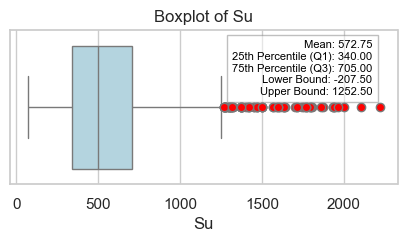

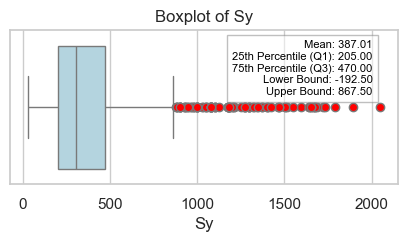

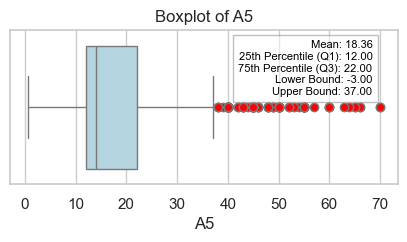

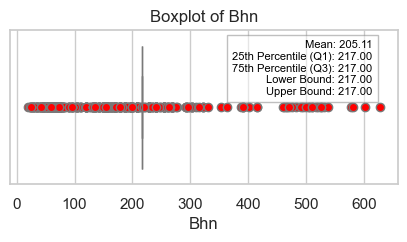

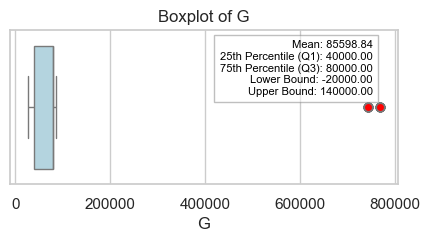

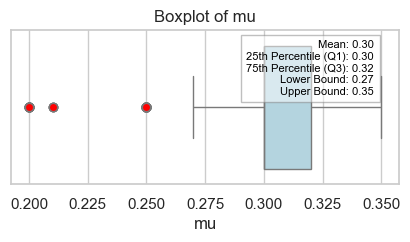

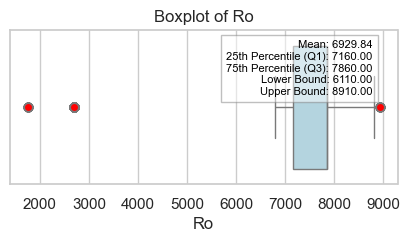

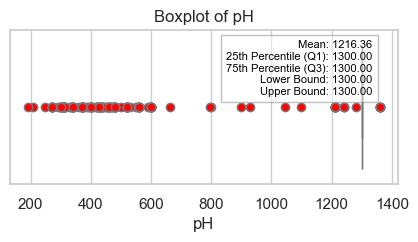

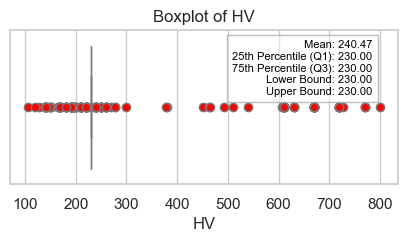

In [157]:
# plot the columns containing outliers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_outliers(df, columns):
    for col in columns:
        plt.figure(figsize=(5, 2))
        sns.boxplot(x=df[col], color='lightblue', flierprops=dict(markerfacecolor='red', marker='o'))
        
        # Calculate statistics
        mean_val = df[col].mean()
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Add text labels for Q1, Q3, mean, lower bound, and upper bound
        stats_text = (f"Mean: {mean_val:.2f}\n"
                      f"25th Percentile (Q1): {Q1:.2f}\n"
                      f"75th Percentile (Q3): {Q3:.2f}\n"
                      f"Lower Bound: {lower_bound:.2f}\n"
                      f"Upper Bound: {upper_bound:.2f}")
        plt.gcf().text(0.85, 0.83, stats_text, fontsize=8, color='black', 
                       ha='right', va='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))
        
        plt.title(f'Boxplot of {col}')
        plt.xlabel(col)
        plt.show()

plot_outliers(df1, outlier_columns)

# remove file if already exists and  export the df1 to a CSV file
import os
if os.path.exists('Data_cleaned.csv'):
    os.remove('Data_cleaned.csv')
df1.to_csv('Data_cleaned.csv', index=False)


In [158]:
# Handle outliers by capping them at lower_bound and upper_bound
for col in outlier_columns:
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df1[col] = df1[col].clip(lower=lower_bound, upper=upper_bound)

# Plot comparison between cleaned data and original data

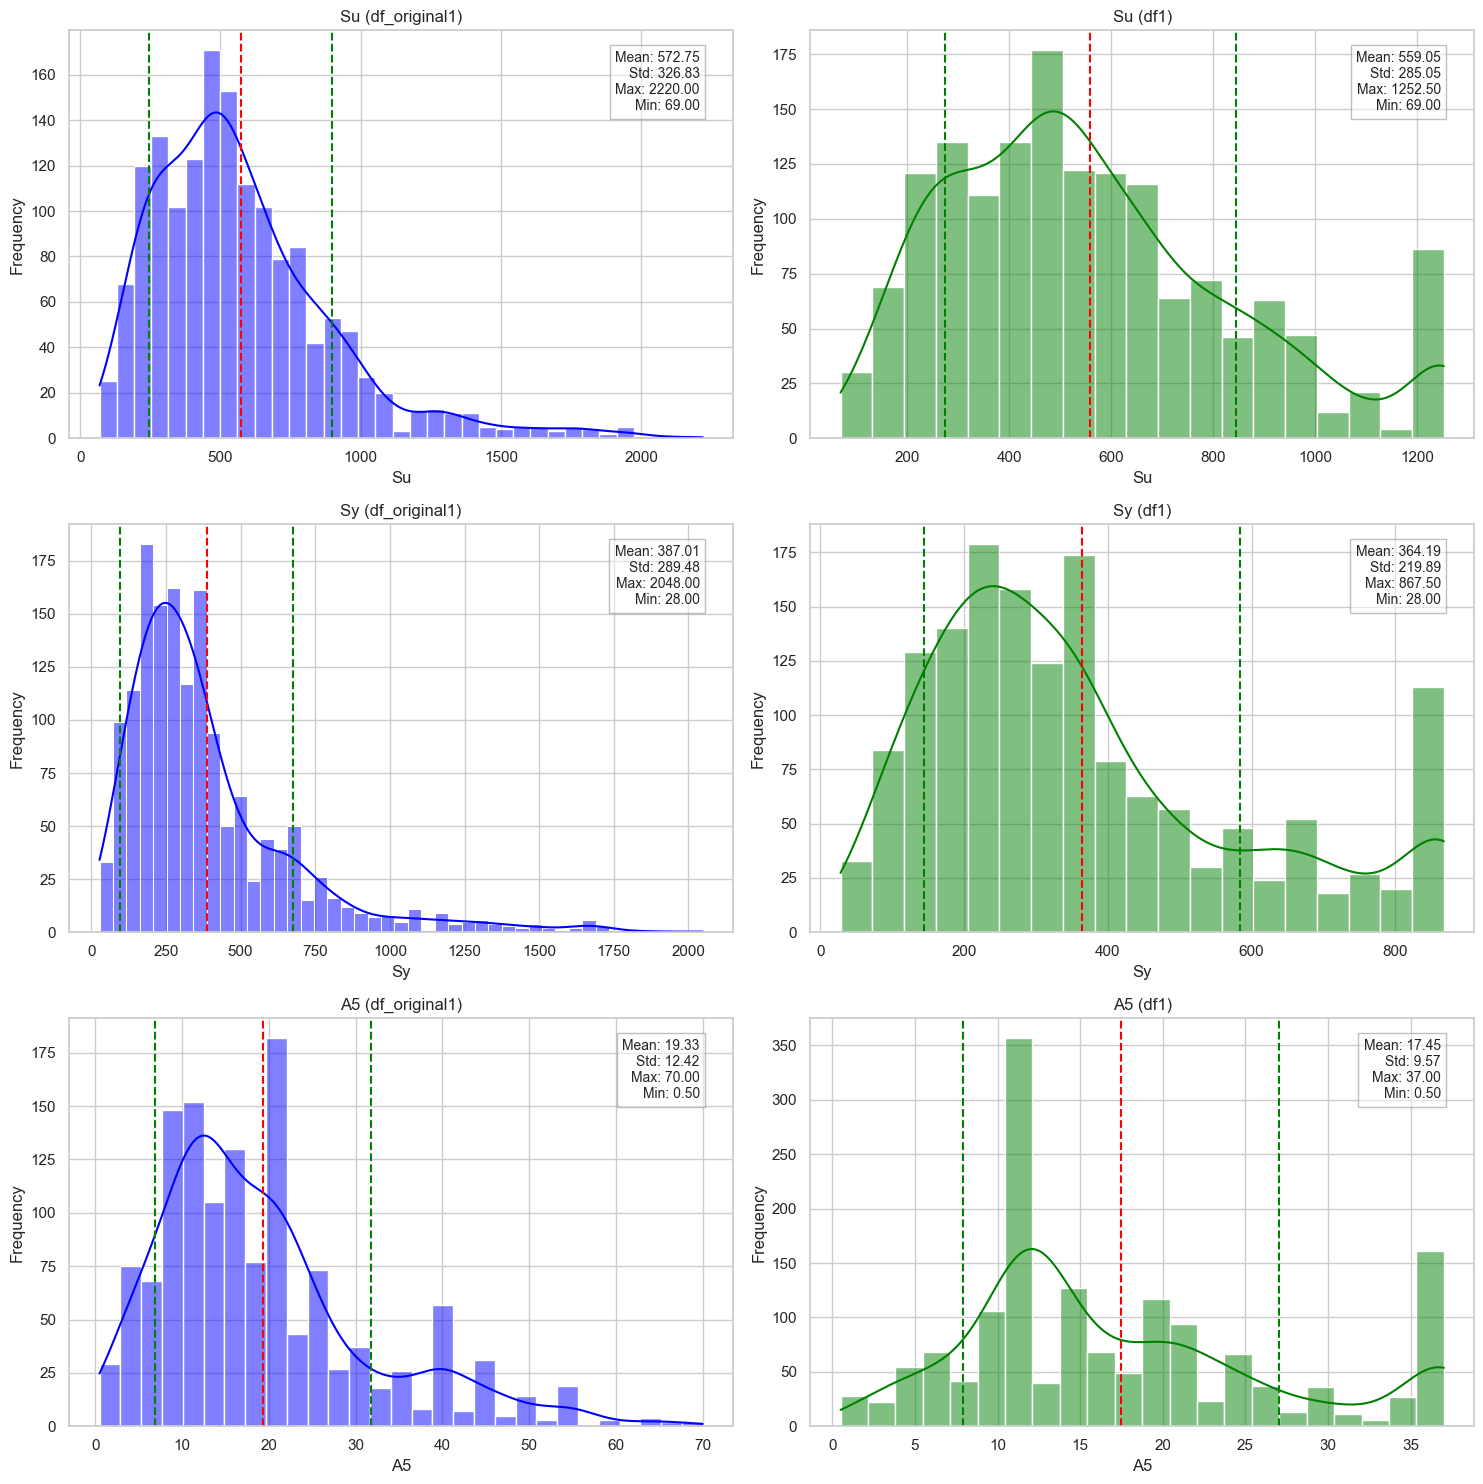

In [159]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_comparison(df_original1, df1, columns):
    # Determine the number of rows and columns for the grid
    num_columns = 2  # Number of plots per row
    num_rows = len(columns)  # One row per column

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))

    for i, col in enumerate(columns):
        # Plot for df_original1
        sns.histplot(df_original1[col], kde=True, ax=axes[i, 0], color='blue')
        mean_val = df_original1[col].mean()
        std_val = df_original1[col].std()
        max_val = df_original1[col].max()
        min_val = df_original1[col].min()
        
        # Add vertical lines for mean and standard deviation
        axes[i, 0].axvline(mean_val, color='red', linestyle='--', label='Mean')
        axes[i, 0].axvline(mean_val + std_val, color='green', linestyle='--', label='Mean + Std')
        axes[i, 0].axvline(mean_val - std_val, color='green', linestyle='--', label='Mean - Std')
        
        # Add text box with statistics
        stats_text = f"Mean: {mean_val:.2f}\nStd: {std_val:.2f}\nMax: {max_val:.2f}\nMin: {min_val:.2f}"
        axes[i, 0].text(0.95, 0.95, stats_text, transform=axes[i, 0].transAxes, fontsize=10,
                        verticalalignment='top', horizontalalignment='right',
                        bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))
        
        axes[i, 0].set_title(f'{col} (df_original1)')
        axes[i, 0].set_xlabel(col)
        axes[i, 0].set_ylabel('Frequency')

        # Plot for df1
        sns.histplot(df1[col], kde=True, ax=axes[i, 1], color='green')
        mean_val_orig = df1[col].mean()
        std_val_orig = df1[col].std()
        max_val_orig = df1[col].max()
        min_val_orig = df1[col].min()
        
        # Add vertical lines for mean and standard deviation
        axes[i, 1].axvline(mean_val_orig, color='red', linestyle='--', label='Mean')
        axes[i, 1].axvline(mean_val_orig + std_val_orig, color='green', linestyle='--', label='Mean + Std')
        axes[i, 1].axvline(mean_val_orig - std_val_orig, color='green', linestyle='--', label='Mean - Std')
        
        # Add text box with statistics
        stats_text_orig = f"Mean: {mean_val_orig:.2f}\nStd: {std_val_orig:.2f}\nMax: {max_val_orig:.2f}\nMin: {min_val_orig:.2f}"
        axes[i, 1].text(0.95, 0.95, stats_text_orig, transform=axes[i, 1].transAxes, fontsize=10,
                        verticalalignment='top', horizontalalignment='right',
                        bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))
        
        axes[i, 1].set_title(f'{col} (df1)')
        axes[i, 1].set_xlabel(col)
        axes[i, 1].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Call the function with the numeric columns
#plot_comparison(df_original1, df1, numeric_columns)
plot_comparison(df_original1, df1, ['Su', 'Sy', 'A5'])

# Check if the file exists, remove it if it does, and then save the cleaned DataFrame to a new CSV file
if os.path.exists('Cleaned_Data.csv'):
    os.remove('Cleaned_Data.csv')

df1.to_csv('Cleaned_Data.csv', index=False)


# Task 2: Groupwise Comparison

# Group average strength, ductility, and hardness values by Material type

In [160]:
# Group average strength, ductility, and hardness values by Material type

df_grouped_Material = df1.groupby('Material').agg({
    'Su': 'mean',
    'Sy': 'mean',
    'A5': 'mean',
    'E': 'mean',
    'G': 'mean',
    'HV': 'mean'
}).reset_index()
print(df_grouped_Material.to_string(index=False))

df_grouped_Heat = df1.groupby('Heat treatment').agg({
    'Su': 'mean',
    'Sy': 'mean',
    'A5': 'mean',
    'E': 'mean',
    'G': 'mean',
    'HV': 'mean'
}).reset_index()
print(df_grouped_Heat.to_string(index=False))

                         Material          Su         Sy        A5             E             G    HV
          Aluminum Alloy 1060-H12   83.000000  76.000000 16.000000  73000.000000  26000.000000 230.0
          Aluminum Alloy 1060-H14   97.000000  90.000000 12.000000  73000.000000  26000.000000 230.0
          Aluminum Alloy 1060-H16  110.000000 103.000000  8.000000  73000.000000  26000.000000 230.0
          Aluminum Alloy 1060-H18  131.000000 124.000000  6.000000  73000.000000  26000.000000 230.0
            Aluminum Alloy 1060-O   69.000000  28.000000 37.000000  73000.000000  26000.000000 230.0
          Aluminum Alloy 1100-H12  110.000000 103.000000 12.000000  73000.000000  26000.000000 230.0
          Aluminum Alloy 1100-H14  124.000000 117.000000  9.000000  73000.000000  26000.000000 230.0
          Aluminum Alloy 1100-H16  145.000000 138.000000  6.000000  73000.000000  26000.000000 230.0
          Aluminum Alloy 1100-H18  165.000000 152.000000  5.000000  73000.000000  26000.000

# Comparing Efficiency with Material and Heat treatment as seperate metrics

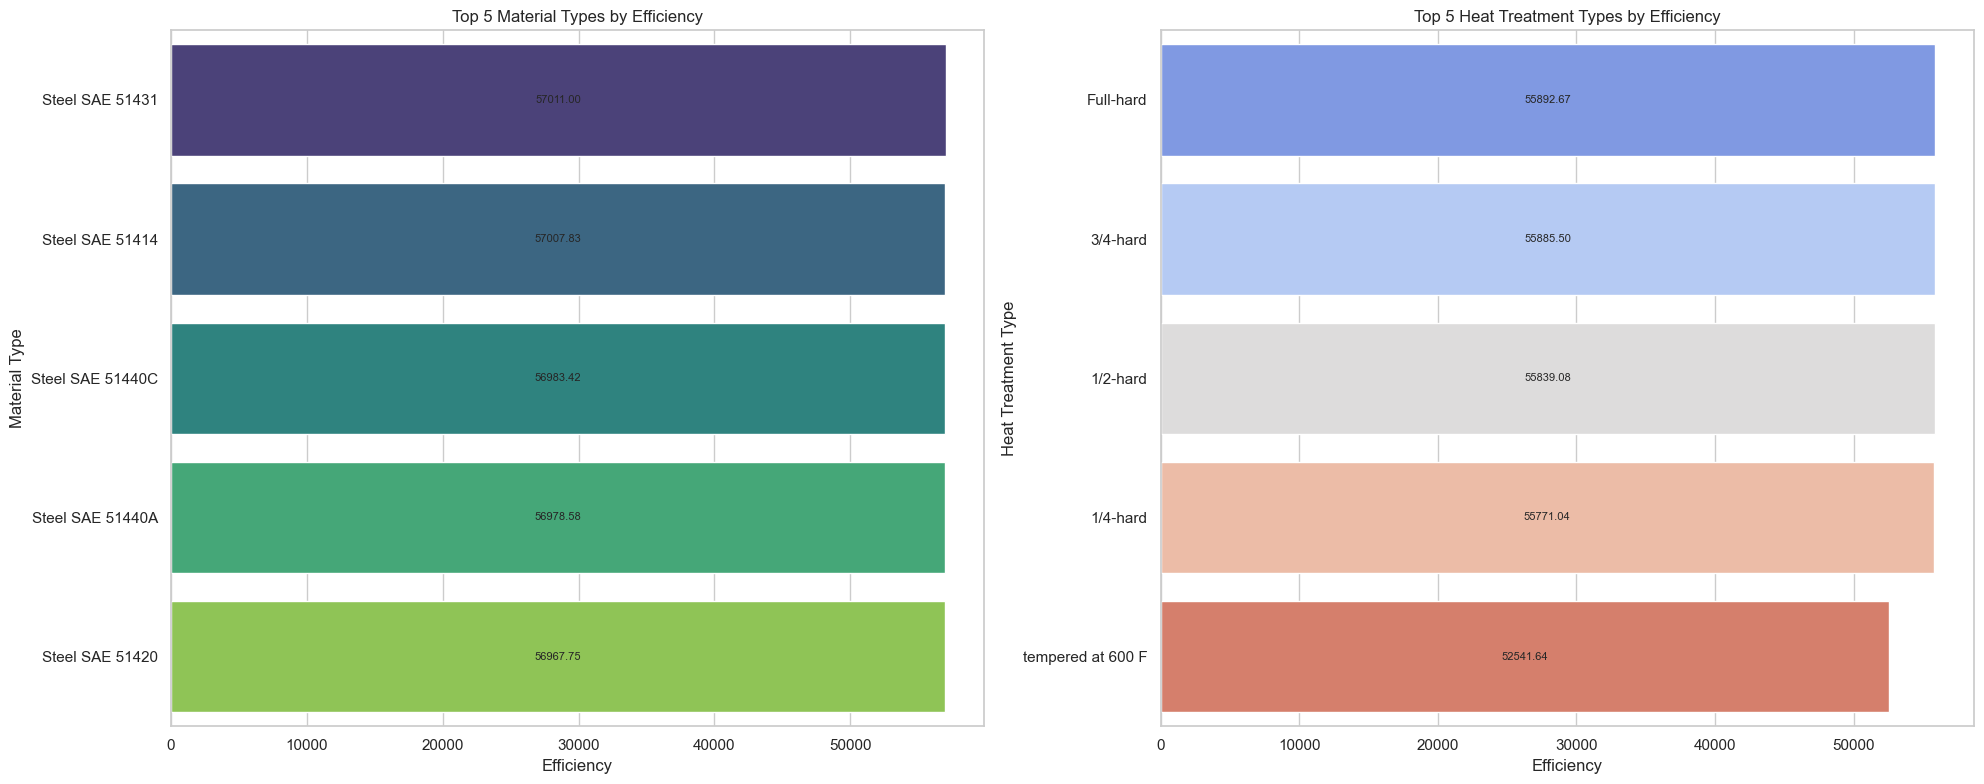

In [161]:
import seaborn as sns

# Define an efficiency metric (e.g., weighted average of properties)
df_grouped_Material['Efficiency'] = (df_grouped_Material['Su'] + df_grouped_Material['Sy'] + df_grouped_Material['A5'] + df_grouped_Material['E'] + df_grouped_Material['G'] + df_grouped_Material['HV']) / 6
df_grouped_Heat['Efficiency'] = (df_grouped_Heat['Su'] + df_grouped_Heat['Sy'] + df_grouped_Heat['A5'] + df_grouped_Heat['E'] + df_grouped_Heat['G'] + df_grouped_Heat['HV']) / 6

# Sort by efficiency
df_grouped_sorted_Material = df_grouped_Material.sort_values(by='Efficiency', ascending=False)
df_grouped_sorted_Heat = df_grouped_Heat.sort_values(by='Efficiency', ascending=False)

# Modify the bar plots to use logarithmic scales for better visualization of differences
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot the efficiency of each material type using a horizontal bar chart with text values
sns.barplot(y='Material', x='Efficiency', data=df_grouped_sorted_Material.head(5), hue='Material', palette='viridis', ax=axes[0], dodge=False)
axes[0].set_title('Top 5 Material Types by Efficiency')
axes[0].set_xlabel('Efficiency')
axes[0].set_ylabel('Material Type')
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.2f', label_type='center', fontsize=8)

# Plot the efficiency of each heat treatment type using a horizontal bar chart with text values
sns.barplot(y='Heat treatment', x='Efficiency', data=df_grouped_sorted_Heat.head(5), hue='Heat treatment', palette='coolwarm', ax=axes[1], dodge=False)
axes[1].set_title('Top 5 Heat Treatment Types by Efficiency')
axes[1].set_xlabel('Efficiency')
axes[1].set_ylabel('Heat Treatment Type')
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.2f', label_type='center', fontsize=8)

plt.tight_layout()
plt.show()

# Group average strength, ductility, and hardness values by Material type and Heat treatment

In [162]:
# Group average strength, ductility, and hardness values by Material type
# Group by both 'Material' and 'Heat treatment' and calculate mean for other columns
df_grouped_strength = df1.groupby(['Material', 'Heat treatment']).agg({
    'Su': 'mean',
    'Sy': 'mean',
    'E': 'mean',
    'G': 'mean'
}).reset_index()

df_grouped_ductility = df1.groupby(['Material', 'Heat treatment']).agg({
    'A5': 'mean'
}).reset_index()

df_grouped_hardness = df1.groupby(['Material', 'Heat treatment']).agg({
    'Bhn': 'mean', 
    'HV': 'mean'
}).reset_index()

print(df_grouped_strength.to_string(index=False))
print(df_grouped_ductility.to_string(index=False))
print(df_grouped_hardness.to_string(index=False))


                         Material                                  Heat treatment          Su         Sy        E             G
          Aluminum Alloy 1060-H12                                         Wrought   83.000000  76.000000  73000.0  26000.000000
          Aluminum Alloy 1060-H14                                         Wrought   97.000000  90.000000  73000.0  26000.000000
          Aluminum Alloy 1060-H16                                         Wrought  110.000000 103.000000  73000.0  26000.000000
          Aluminum Alloy 1060-H18                                         Wrought  131.000000 124.000000  73000.0  26000.000000
            Aluminum Alloy 1060-O                                         Wrought   69.000000  28.000000  73000.0  26000.000000
          Aluminum Alloy 1100-H12                                         Wrought  110.000000 103.000000  73000.0  26000.000000
          Aluminum Alloy 1100-H14                                         Wrought  124.000000 117.000000

# Plot average strength, ductility, and hardness values by Material type and Heat treatment

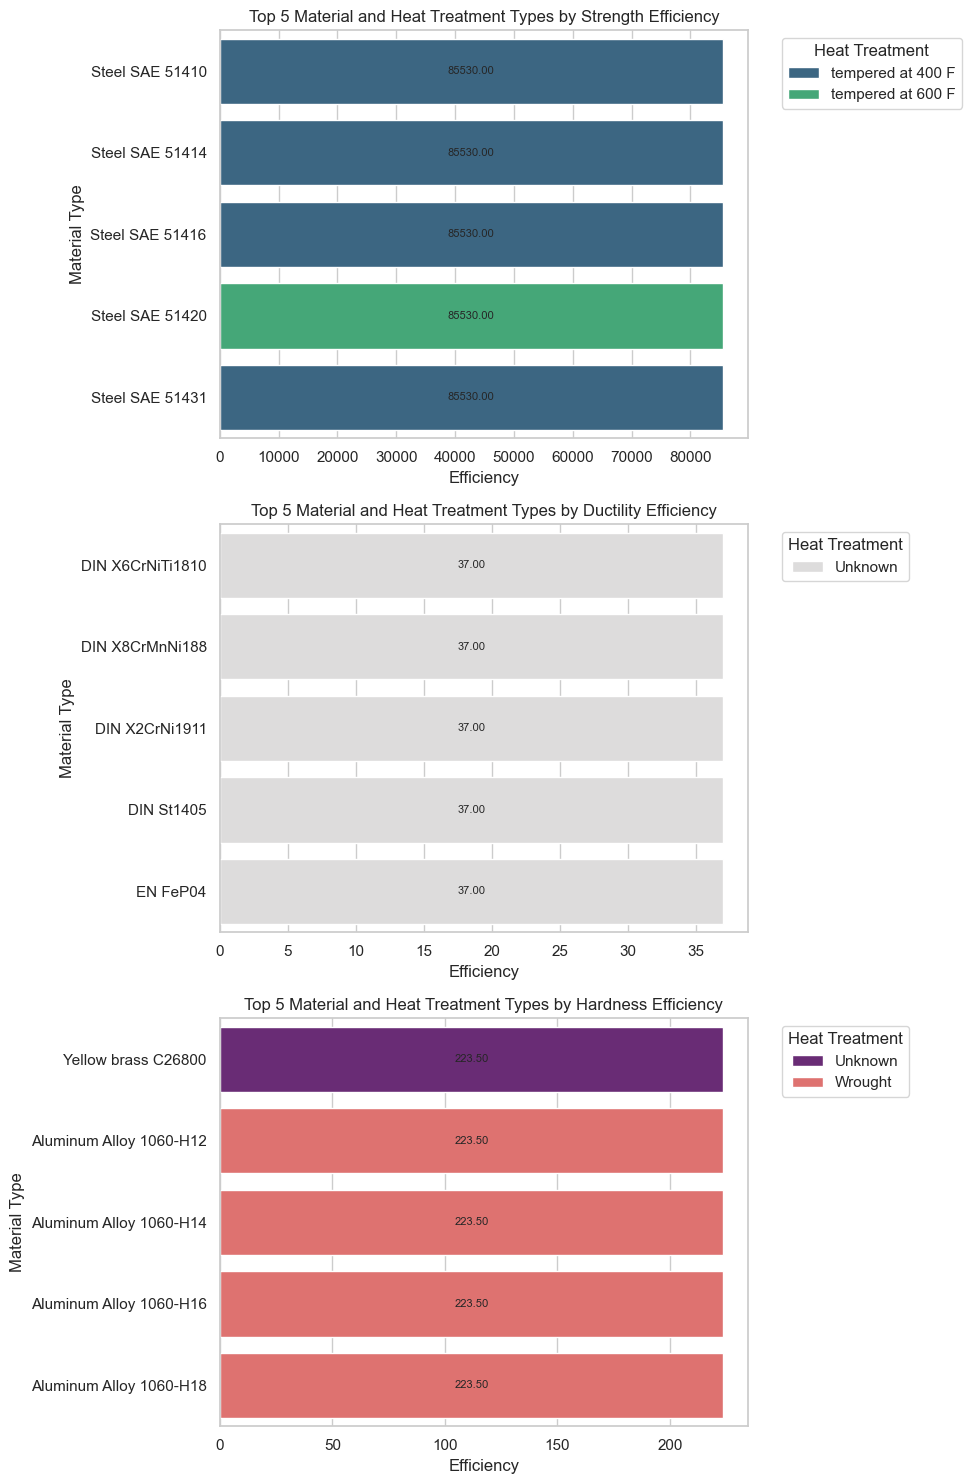

In [163]:
import seaborn as sns

# Define an efficiency metric (e.g., weighted average of properties)
df_grouped_strength['Efficiency'] = (df_grouped_strength['Su'] 
                                     + df_grouped_strength['Sy'] 
                                     + df_grouped_strength['E'] 
                                     + df_grouped_strength['G']) / 4
df_grouped_ductility['Efficiency'] = df_grouped_ductility['A5'] / 1
df_grouped_hardness['Efficiency'] = (df_grouped_hardness['Bhn'] 
                                     + df_grouped_hardness['HV']) / 2 

# Sort by efficiency
df_grouped_sorted_strength = df_grouped_strength.sort_values(by='Efficiency', ascending=False)
df_grouped_sorted_ductility = df_grouped_ductility.sort_values(by='Efficiency', ascending=False)
df_grouped_sorted_hardness = df_grouped_hardness.sort_values(by='Efficiency', ascending=False)

# Create subplots for strength, ductility, and hardness grouped by both Material and Heat treatment
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot the efficiency of each material and heat treatment type for strength
sns.barplot(y='Material', x='Efficiency', hue='Heat treatment', data=df_grouped_sorted_strength.head(5), palette='viridis', ax=axes[0], dodge=False)
axes[0].set_title('Top 5 Material and Heat Treatment Types by Strength Efficiency')
axes[0].set_xlabel('Efficiency')
axes[0].set_ylabel('Material Type')
axes[0].legend(title='Heat Treatment', bbox_to_anchor=(1.05, 1), loc='upper left')
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.2f', label_type='center', fontsize=8)

# Plot the efficiency of each material and heat treatment type for ductility
sns.barplot(y='Material', x='Efficiency', hue='Heat treatment', data=df_grouped_sorted_ductility.head(5), palette='coolwarm', ax=axes[1], dodge=False)
axes[1].set_title('Top 5 Material and Heat Treatment Types by Ductility Efficiency')
axes[1].set_xlabel('Efficiency')
axes[1].set_ylabel('Material Type')
axes[1].legend(title='Heat Treatment', bbox_to_anchor=(1.05, 1), loc='upper left')
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.2f', label_type='center', fontsize=8)

# Plot the efficiency of each material and heat treatment type for hardness
sns.barplot(y='Material', x='Efficiency', hue='Heat treatment', data=df_grouped_sorted_hardness.head(5), palette='magma', ax=axes[2], dodge=False)
axes[2].set_title('Top 5 Material and Heat Treatment Types by Hardness Efficiency')
axes[2].set_xlabel('Efficiency')
axes[2].set_ylabel('Material Type')
axes[2].legend(title='Heat Treatment', bbox_to_anchor=(1.05, 1), loc='upper left')
for container in axes[2].containers:
    axes[2].bar_label(container, fmt='%.2f', label_type='center', fontsize=8)

plt.tight_layout()
plt.show()
    

In [164]:
print("Top 5 Material Efficiency:")
print(df_grouped_sorted_Material.head(5).to_string(index=False))

print("\nTop 5 Heat Treatment Types Efficiency:")
print(df_grouped_sorted_Heat.head(5).to_string(index=False))

print("\nTop 5 Material and Heat Treatment Types by Strength Efficiency:")
print(df_grouped_sorted_strength.head(5).to_string(index=False))

print("\nTop 5 Material and Heat Treatment Types by Ductility Efficiency:")
print(df_grouped_sorted_ductility.head(5).to_string(index=False))

print("\nTop 5 Material and Heat Treatment Types by Hardness Efficiency:")
print(df_grouped_sorted_hardness.head(5).to_string(index=False))

Top 5 Material Efficiency:
        Material      Su     Sy   A5        E        G    HV   Efficiency
 Steel SAE 51431 1057.25 761.25 17.5 200000.0 140000.0 230.0 57011.000000
 Steel SAE 51414 1039.75 761.25 16.0 200000.0 140000.0 230.0 57007.833333
Steel SAE 51440C 1005.25 657.75  7.5 200000.0 140000.0 230.0 56983.416667
Steel SAE 51440A  988.25 640.75 12.5 200000.0 140000.0 230.0 56978.583333
 Steel SAE 51420  953.75 606.25 16.5 200000.0 140000.0 230.0 56967.750000

Top 5 Heat Treatment Types Efficiency:
   Heat treatment     Su         Sy    A5        E        G    HV   Efficiency
        Full-hard 1252.5 867.500000  6.00 193000.0 140000.0 230.0 55892.666667
         3/4-hard 1207.0 867.500000  8.50 193000.0 140000.0 230.0 55885.500000
         1/2-hard 1034.0 758.000000 12.50 193000.0 140000.0 230.0 55839.083333
         1/4-hard  862.0 517.000000 17.25 193000.0 140000.0 230.0 55771.041667
tempered at 600 F 1182.0 828.833333  9.00 203500.0 109500.0 230.0 52541.638889

Top 5 Material

# Task 3: Design Ratio Analysis

In [165]:
import pandas as pd

# Calculate the custom metrics
df1['Strength_Hardness'] = df1['Su'] / df1['Bhn']           
df1['Strength_Ductility'] = df1['Su'] * df1['A5']           
df1['Strength_Weight'] = df1['Su'] / df1['Ro']              

# Rank the materials based on the custom metrics
df1['Strength_Hardness_Rank'] = df1['Strength_Hardness'].rank(ascending=False, method='dense')
df1['Strength_Ductility_Rank'] = df1['Strength_Ductility'].rank(ascending=False, method='dense')
df1['Strength_Weight_Rank'] = df1['Strength_Weight'].rank(ascending=False, method='dense')

# Save the DataFrame with custom metrics to a new CSV file
# delete the csv file if it exists
import os
if os.path.exists('Data_with_custom_metrics.csv'):
    os.remove('Data_with_custom_metrics.csv')

df1.to_csv('Data_with_custom_metrics.csv', index=False)


In [166]:
print("Top 5 Materials by Strength-to-Hardness Ratio:")

strength_hardness_table = df1[['Material', 'Strength_Hardness', 'Strength_Hardness_Rank']].sort_values(by='Strength_Hardness_Rank').head(5)
if os.path.exists('Top_5_Strength_Hardness.csv'):
    os.remove('Top_5_Strength_Hardness.csv')
strength_hardness_table.to_csv('Top_5_Strength_Hardness.csv', index=False)
print(strength_hardness_table.to_string(index=False))

print("\nTop 5 Materials by Strength-to-Ductility Index:")

strength_ductility_table = df1[['Material', 'Strength_Ductility', 'Strength_Ductility_Rank']].sort_values(by='Strength_Ductility_Rank').head(5)
if os.path.exists('Top_5_Strength_Ductility.csv'):
    os.remove('Top_5_Strength_Ductility.csv')
strength_ductility_table.to_csv('Top_5_Strength_Ductility.csv', index=False)
print(strength_ductility_table.to_string(index=False))

print("\nTop 5 Materials by Strength-to-Weight Proxy:")

strength_weight_table = df1[['Material', 'Strength_Weight', 'Strength_Weight_Rank']].sort_values(by='Strength_Weight_Rank').head(5)
if os.path.exists('Top_5_Strength_Weight.csv'):
    os.remove('Top_5_Strength_Weight.csv')
strength_weight_table.to_csv('Top_5_Strength_Weight.csv', index=False)
print(strength_weight_table.to_string(index=False))

Top 5 Materials by Strength-to-Hardness Ratio:
      Material  Strength_Hardness  Strength_Hardness_Rank
Steel SAE 1141           5.771889                     1.0
     DIN 55Cr3           5.771889                     1.0
     DIN 37Cr4           5.771889                     1.0
    DIN 50CrV4           5.771889                     1.0
Steel SAE 1340           5.771889                     1.0

Top 5 Materials by Strength-to-Ductility Index:
                        Material  Strength_Ductility  Strength_Ductility_Rank
                 Steel SAE 30201             29341.0                      1.0
                 Steel SAE 30301             28046.0                      2.0
                 Steel SAE 30202             26788.0                      3.0
Steel 12Ch25N16G7AR GOST 5949-75             25530.0                      4.0
                 Steel SAE 30314             25493.0                      5.0

Top 5 Materials by Strength-to-Weight Proxy:
                    Material  Strength_Wei

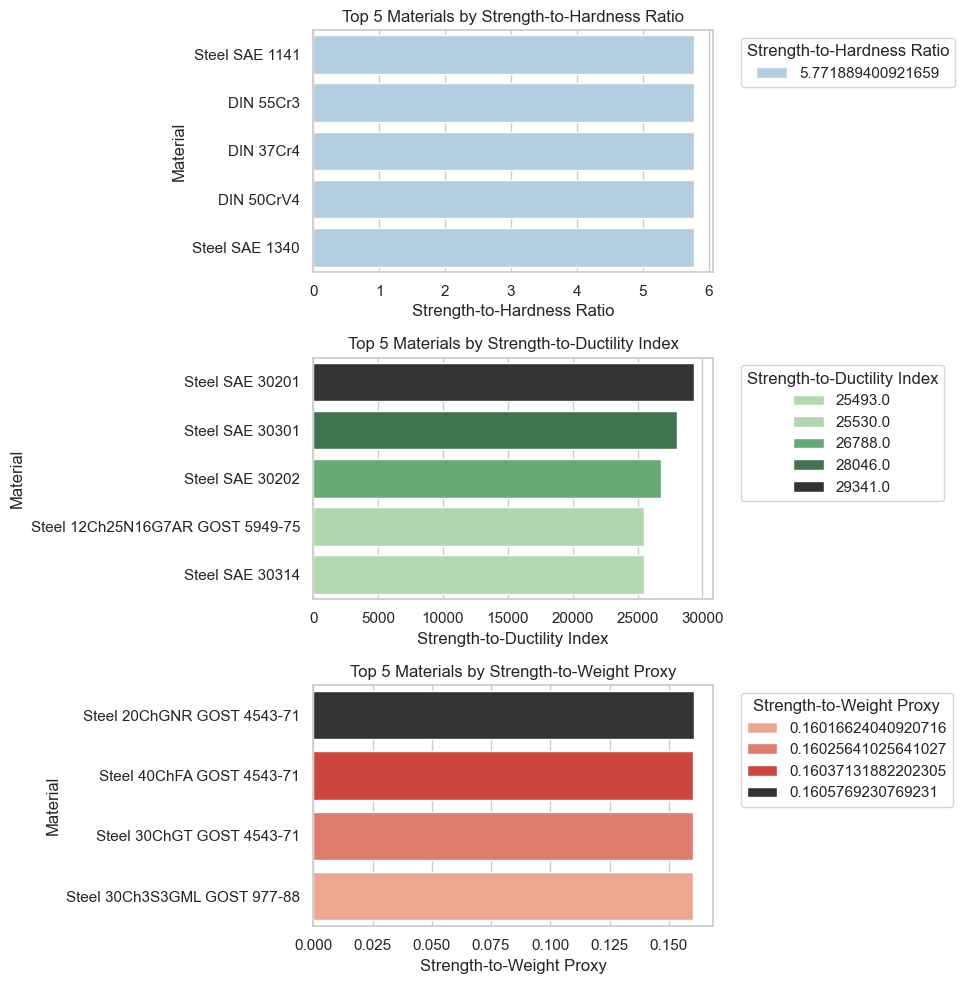

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# Plot Strength-to-Hardness Ratio
sns.barplot(x='Strength_Hardness', y='Material', data=strength_hardness_table, hue='Strength_Hardness', ax=axes[0], palette='Blues_d')
axes[0].set_title('Top 5 Materials by Strength-to-Hardness Ratio')
axes[0].set_xlabel('Strength-to-Hardness Ratio')
axes[0].set_ylabel('Material')
axes[0].legend(title='Strength-to-Hardness Ratio', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot Strength-to-Ductility Index
sns.barplot(x='Strength_Ductility', y='Material', data=strength_ductility_table, hue = 'Strength_Ductility', ax=axes[1], palette='Greens_d')
axes[1].set_title('Top 5 Materials by Strength-to-Ductility Index')
axes[1].set_xlabel('Strength-to-Ductility Index')
axes[1].set_ylabel('Material')
axes[1].legend(title='Strength-to-Ductility Index', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot Strength-to-Weight Proxy
sns.barplot(x='Strength_Weight', y='Material', data=strength_weight_table, hue = 'Strength_Weight', ax=axes[2], palette='Reds_d')
axes[2].set_title('Top 5 Materials by Strength-to-Weight Proxy')
axes[2].set_xlabel('Strength-to-Weight Proxy')
axes[2].set_ylabel('Material')
axes[2].legend(title='Strength-to-Weight Proxy', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout
plt.tight_layout()
plt.show()

# Task 4: Hardness Scale Correlation

In [168]:
#Group the data by Material and Heat treatment separetely and calculate the mean for Bhn and HV
df_grouped_hardness_material = df1.groupby('Material').agg({
    'Bhn': 'mean',
    'HV': 'mean'
}).reset_index()
print("\nHardness Scale by Material Type:")

print(df_grouped_hardness_material.head(10).to_string(index=False))



Hardness Scale by Material Type:
               Material   Bhn    HV
Aluminum Alloy 1060-H12 217.0 230.0
Aluminum Alloy 1060-H14 217.0 230.0
Aluminum Alloy 1060-H16 217.0 230.0
Aluminum Alloy 1060-H18 217.0 230.0
  Aluminum Alloy 1060-O 217.0 230.0
Aluminum Alloy 1100-H12 217.0 230.0
Aluminum Alloy 1100-H14 217.0 230.0
Aluminum Alloy 1100-H16 217.0 230.0
Aluminum Alloy 1100-H18 217.0 230.0
  Aluminum Alloy 1100-O 217.0 230.0


# Relationship Between Brinell (Bhn) and Vickers (HV) Hardness

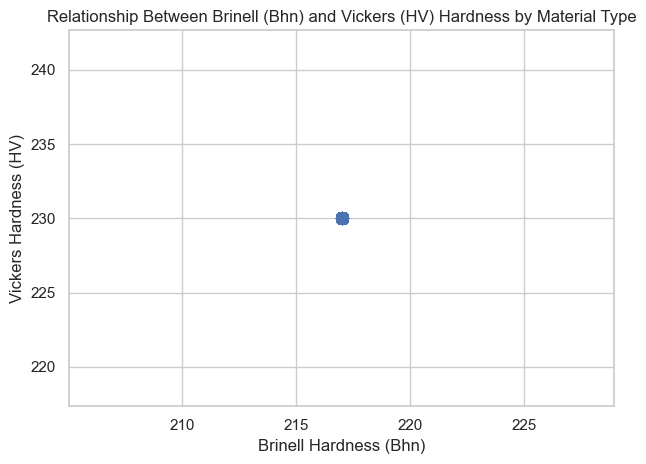

In [169]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Plot 1: Relationship Between Brinell (Bhn) and Vickers (HV) Hardness by Material Type
sns.set(style="whitegrid")
sns.regplot(x='Bhn', y='HV', data=df_grouped_hardness_material, scatter_kws={'s': 70}, line_kws={"color": "red"})
plt.title('Relationship Between Brinell (Bhn) and Vickers (HV) Hardness by Material Type')
plt.xlabel('Brinell Hardness (Bhn)')
plt.ylabel('Vickers Hardness (HV)')

# Adjust layout
plt.tight_layout()
plt.show()


# Plot bar chart to confirm visually that values are constant.

Bhn Unique Values: [217.]
HV Unique Values: [230.]
Correlation between Bhn and HV: nan


g:\DIY Guru\Data-Science-and-Engineering-Analytics\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


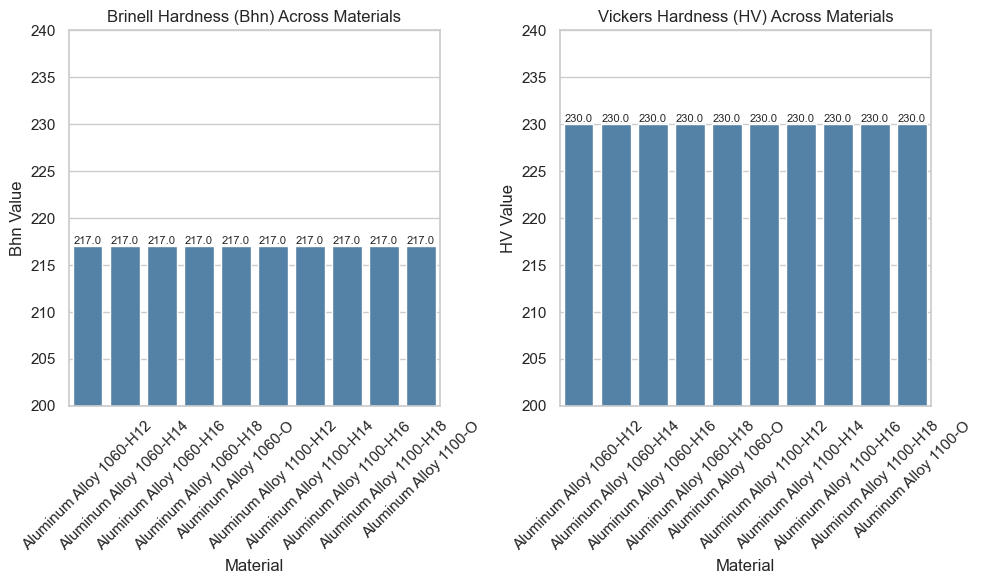

In [170]:
import seaborn as sns
import matplotlib.pyplot as plt

print("Bhn Unique Values:", df1['Bhn'].unique())
print("HV Unique Values:", df1['HV'].unique())
# print the correlation between Bhn and HV
print("Correlation between Bhn and HV:", df1['Bhn'].corr(df1['HV']))

# Create a figure with 1 row and 2 columns of subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plot 1: Brinell Hardness (Bhn) Across Materials
sns.barplot(data=df_grouped_hardness_material.head(10), x='Material', y='Bhn', color='steelblue', ax=axes[0])
axes[0].set_title("Brinell Hardness (Bhn) Across Materials")
axes[0].set_ylabel("Bhn Value")
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(200, 240)
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.1f', label_type='edge', fontsize=8)

# Plot 2: Vickers Hardness (HV) Across Materials
sns.barplot(data=df_grouped_hardness_material.head(10), x='Material', y='HV', color='steelblue', ax=axes[1])
axes[1].set_title("Vickers Hardness (HV) Across Materials")
axes[1].set_ylabel("HV Value")
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_ylim(200, 240)
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.1f', label_type='edge', fontsize=8)


# Adjust layout
plt.tight_layout()
plt.show()


# Detect & Plot Divergence Between Bhn and HV

Diverging Material Samples:
                      Material    Bhn     HV  Bhn_HV_Diff
0     Aluminum Alloy 1060-H12  217.0  230.0         13.0
1     Aluminum Alloy 1060-H14  217.0  230.0         13.0
2     Aluminum Alloy 1060-H16  217.0  230.0         13.0
3     Aluminum Alloy 1060-H18  217.0  230.0         13.0
4       Aluminum Alloy 1060-O  217.0  230.0         13.0
...                       ...    ...    ...          ...
1220      Yellow Brass C85400  217.0  230.0         13.0
1221      Yellow Brass C85500  217.0  230.0         13.0
1222      Yellow Brass C85700  217.0  230.0         13.0
1223      Yellow Brass C85800  217.0  230.0         13.0
1224      Yellow brass C26800  217.0  230.0         13.0

[1225 rows x 4 columns]


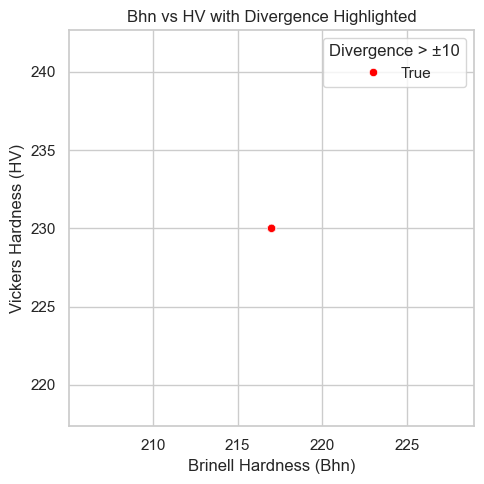

In [171]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Step 1: Calculate the difference between Bhn and HV
df_grouped_hardness_material['Bhn_HV_Diff'] = df_grouped_hardness_material['HV'] - df_grouped_hardness_material['Bhn']

# Step 2: Flag diverging pairs
threshold = 10  # Tolerance threshold for acceptable difference
df_grouped_hardness_material['Divergence_Flag'] = df_grouped_hardness_material['Bhn_HV_Diff'].abs() > threshold

# Step 3: Print diverging rows
diverging_rows = df_grouped_hardness_material[df_grouped_hardness_material['Divergence_Flag']]
print("Diverging Material Samples:\n", diverging_rows[['Material', 'Bhn', 'HV', 'Bhn_HV_Diff']])

# Step 4: Plot the comparison with regression
plt.figure(figsize=(5, 5))
sns.scatterplot(data=df_grouped_hardness_material, x='Bhn', y='HV', hue='Divergence_Flag', palette={True: 'red', False: 'green'})
sns.regplot(data=df_grouped_hardness_material, x='Bhn', y='HV', scatter=False, color='black', line_kws={"linestyle":"--"})

plt.title("Bhn vs HV with Divergence Highlighted")
plt.xlabel("Brinell Hardness (Bhn)")
plt.ylabel("Vickers Hardness (HV)")
plt.legend(title='Divergence > ±10')
plt.tight_layout()
plt.show()


# Task 5: Elasticity and Deformability Insight

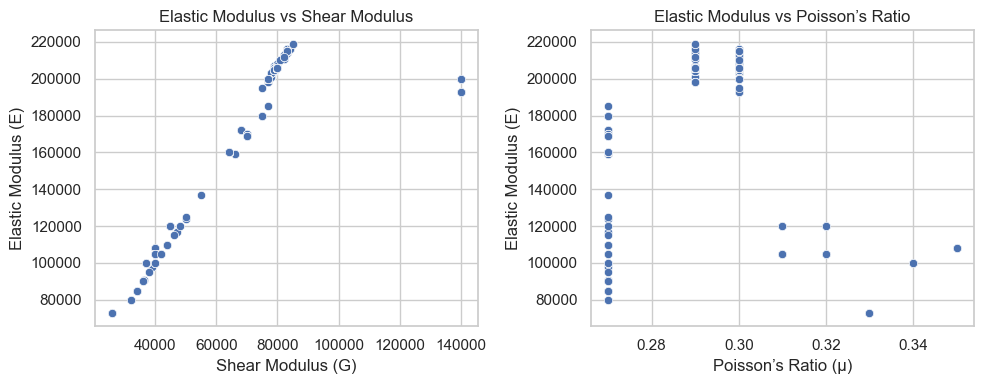

In [172]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate theoretical E from G and mu
df1['E_calc'] = 2 * df1['G'] * (1 + df1['mu'])

# Calculate error or deviation
df1['Deviation (%)'] = 100 * abs(df1['E'] - df1['E_calc']) / df1['E']

# Plot E vs G
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.scatterplot(data=df1, x='G', y='E')
plt.title('Elastic Modulus vs Shear Modulus')
plt.xlabel('Shear Modulus (G)')
plt.ylabel('Elastic Modulus (E)')


# Plot E vs μ
plt.subplot(1, 2, 2)
sns.scatterplot(data=df1, x='mu', y='E')
plt.title('Elastic Modulus vs Poisson’s Ratio')
plt.xlabel('Poisson’s Ratio (μ)')
plt.ylabel('Elastic Modulus (E)')

plt.tight_layout()
plt.show()

# Task 6: Environmental Compatibility

In [173]:
# Categorize pH into Acidic, Neutral, or Basic
def categorize_pH(pH):
    if pH < 6:
        return 'Acidic'
    elif 6 <= pH <= 8:
        return 'Neutral'
    else:
        return 'Basic'

# Apply the function to your DataFrame
df1['pH_Category'] = df1['pH'].apply(categorize_pH)
# unique values in pH_category
print("Unique values in pH_Category:", df1['pH_Category'].unique())


Unique values in pH_Category: ['Basic']


# Correlation between various mechanical properties of materials.

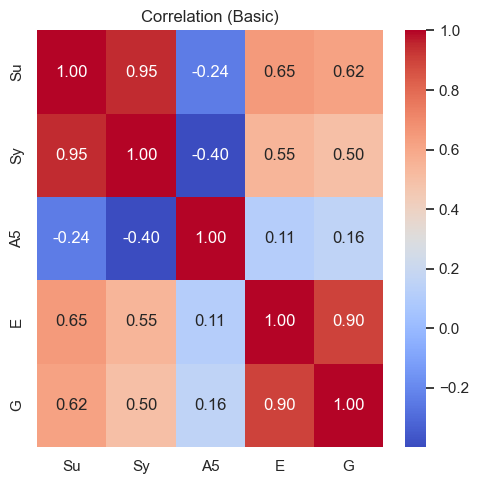

In [174]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Categorize pH groups
def categorize_ph(pH):
    if pH < 6:
        return 'Acidic'
    elif 6 <= pH <= 8:
        return 'Neutral'
    else:
        return 'Basic'

df1['pH_category'] = df1['pH'].apply(categorize_ph)

# Step 2: Heatmap of correlations between mechanical properties by pH category
categories = df1['pH_category'].unique()
num_categories = len(categories)

# Create subplots for each category
fig, axes = plt.subplots(1, num_categories, figsize=(5 * num_categories, 5), sharey=True)

# Handle the case where there is only one category
if num_categories == 1:
    axes = [axes]  # Convert single Axes object to a list for consistency

for i, category in enumerate(categories):
    category_data = df1[df1['pH_category'] == category]
    correlation_matrix = category_data[['Su', 'Sy', 'A5', 'E', 'G']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, ax=axes[i])
    axes[i].set_title(f"Correlation ({category})")

plt.tight_layout()
plt.show()


# Mechanical properties across the pH categories

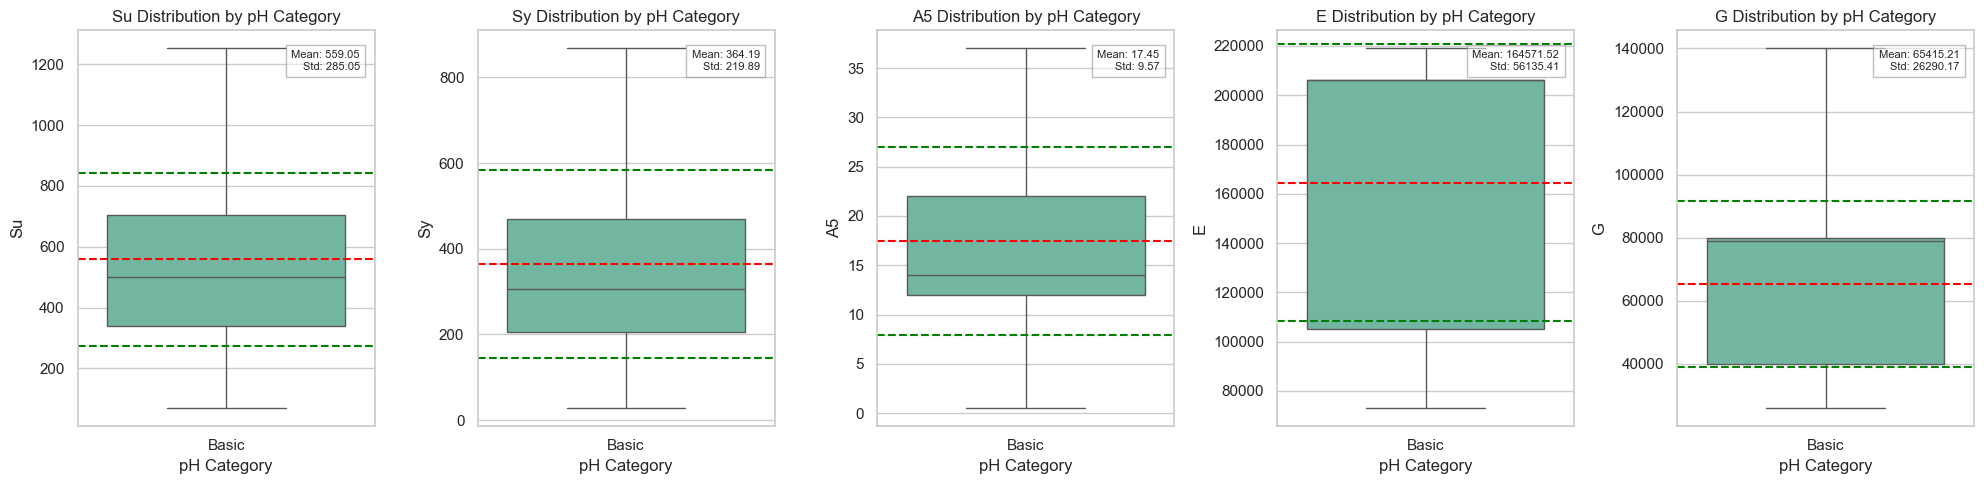

In [175]:
# Create subplots for all properties
properties = ['Su', 'Sy', 'A5', 'E', 'G']

fig, axes = plt.subplots(1,len(properties), figsize=(4 * len(properties),5))

for i, prop in enumerate(properties):
    sns.boxplot(x='pH_category', y=prop, data=df1, palette='Set2', hue='pH_category', ax=axes[i])
    axes[i].set_title(f'{prop} Distribution by pH Category')
    
    # Mean and std value lines
    mean_val = df1[prop].mean()
    std_val = df1[prop].std()
    axes[i].axhline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axes[i].axhline(mean_val + std_val, color='green', linestyle='--', label=f'Mean + Std: {mean_val + std_val:.2f}')
    axes[i].axhline(mean_val - std_val, color='green', linestyle='--', label=f'Mean - Std: {mean_val - std_val:.2f}')
    
    # Add text box with statistics
    stats_text = f"Mean: {mean_val:.2f}\nStd: {std_val:.2f}"
    axes[i].text(0.95, 0.95, stats_text, transform=axes[i].transAxes, fontsize=8,
                 verticalalignment='top', horizontalalignment='right',
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))
    
    axes[i].set_xlabel("pH Category")
    axes[i].set_ylabel(prop)

# Adjust layout
plt.tight_layout()
plt.show()